In [4]:
import tensorflow as tf
from keras.datasets import cifar100
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, Activation, Lambda, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import datetime, os
import time
import pandas as pd
import seaborn as sns
from tensorflow.keras.applications import VGG19

%load_ext tensorboard

In [1]:
from deakin.edu.au.data import Cifar100
import deakin.edu.au.models as models
from tensorflow.keras.utils import plot_model
from graphviz import Digraph

2021-07-18 22:10:24.017893: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-18 22:10:25.076883: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-18 22:10:25.146145: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2021-07-18 22:10:25.146234: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-18 22:10:25.151745: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-18 22:10:25.151881: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas

In [2]:
#Load dataset
dataset = Cifar100()
num_classes = [dataset.num_classes_l0, dataset.num_classes_l1, dataset.num_classes_l2]
u = dataset.draw_taxonomy()
u.view()


'diagram8.pdf'

In [5]:
batch = 128
epochs = 50
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
# global_accuracy_callback = global_accuracy(dataset.X_val, dataset.y_val)


Model: "MLPH_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten (Flatten)               (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
out_level_0 (Dense)             (None, 2)            1026        flatten[0][0]                    
_________________________________________________________________________________________

2021-07-18 21:36:33.731306: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-18 21:36:33.749197: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3600000000 Hz


Epoch 1/50


2021-07-18 21:36:34.728638: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-07-18 21:36:35.179896: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2021-07-18 21:36:35.747063: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-18 21:36:36.131390: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


391/391 [==============================] - 17s 36ms/step - loss: 3.0900 - out_level_0_loss: 0.6535 - out_level_1_loss: 3.3605 - out_level_2_loss: 5.2559 - out_level_0_accuracy: 0.7600 - out_level_1_accuracy: 0.1195 - out_level_2_accuracy: 0.0187 - val_loss: 2.5120 - val_out_level_0_loss: 0.4007 - val_out_level_1_loss: 2.6071 - val_out_level_2_loss: 4.5281 - val_out_level_0_accuracy: 0.8230 - val_out_level_1_accuracy: 0.1958 - val_out_level_2_accuracy: 0.0326
Epoch 2/50
391/391 [==============================] - 13s 33ms/step - loss: 2.3704 - out_level_0_loss: 0.3579 - out_level_1_loss: 2.3647 - out_level_2_loss: 4.3885 - out_level_0_accuracy: 0.8500 - out_level_1_accuracy: 0.2908 - out_level_2_accuracy: 0.0543 - val_loss: 2.2503 - val_out_level_0_loss: 0.3412 - val_out_level_1_loss: 2.1556 - val_out_level_2_loss: 4.2542 - val_out_level_0_accuracy: 0.8592 - val_out_level_1_accuracy: 0.3502 - val_out_level_2_accuracy: 0.0680
Epoch 3/50
391/391 [==============================] - 13s 34ms/

391/391 [==============================] - 13s 34ms/step - loss: 0.4723 - out_level_0_loss: 0.0404 - out_level_1_loss: 0.4488 - out_level_2_loss: 0.9278 - out_level_0_accuracy: 0.9863 - out_level_1_accuracy: 0.8555 - out_level_2_accuracy: 0.7351 - val_loss: 1.2492 - val_out_level_0_loss: 0.2851 - val_out_level_1_loss: 1.3244 - val_out_level_2_loss: 2.1381 - val_out_level_0_accuracy: 0.9260 - val_out_level_1_accuracy: 0.6556 - val_out_level_2_accuracy: 0.5010
Epoch 19/50
391/391 [==============================] - 13s 34ms/step - loss: 0.4186 - out_level_0_loss: 0.0335 - out_level_1_loss: 0.3918 - out_level_2_loss: 0.8305 - out_level_0_accuracy: 0.9888 - out_level_1_accuracy: 0.8732 - out_level_2_accuracy: 0.7607 - val_loss: 1.3012 - val_out_level_0_loss: 0.3032 - val_out_level_1_loss: 1.3828 - val_out_level_2_loss: 2.2174 - val_out_level_0_accuracy: 0.9240 - val_out_level_1_accuracy: 0.6636 - val_out_level_2_accuracy: 0.5050
Epoch 20/50
391/391 [==============================] - 13s 33m

391/391 [==============================] - 13s 33ms/step - loss: 0.0303 - out_level_0_loss: 0.0048 - out_level_1_loss: 0.0277 - out_level_2_loss: 0.0585 - out_level_0_accuracy: 0.9984 - out_level_1_accuracy: 0.9922 - out_level_2_accuracy: 0.9866 - val_loss: 2.6632 - val_out_level_0_loss: 0.7604 - val_out_level_1_loss: 3.0068 - val_out_level_2_loss: 4.2224 - val_out_level_0_accuracy: 0.9254 - val_out_level_1_accuracy: 0.6522 - val_out_level_2_accuracy: 0.4942
Epoch 36/50
391/391 [==============================] - 13s 34ms/step - loss: 0.0474 - out_level_0_loss: 0.0118 - out_level_1_loss: 0.0449 - out_level_2_loss: 0.0857 - out_level_0_accuracy: 0.9960 - out_level_1_accuracy: 0.9858 - out_level_2_accuracy: 0.9767 - val_loss: 2.4198 - val_out_level_0_loss: 0.6576 - val_out_level_1_loss: 2.7476 - val_out_level_2_loss: 3.8543 - val_out_level_0_accuracy: 0.9276 - val_out_level_1_accuracy: 0.6602 - val_out_level_2_accuracy: 0.4998
Epoch 37/50
391/391 [==============================] - 13s 34m

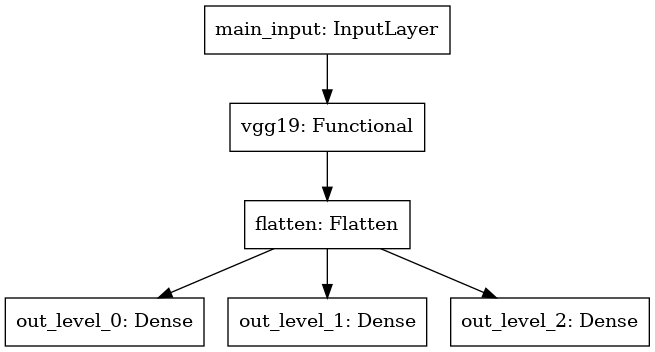

In [6]:
# Create the model
MLPH_model = models.get_MLPH_model(num_classes, dataset.image_size)
MLPH_model.summary()
plot_model(MLPH_model)
#train model
history_MLPH_model = MLPH_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
#                     callbacks=[global_accuracy_callback, early_stopping_callback]
                    )


dict_keys(['loss', 'out_level_0_loss', 'out_level_1_loss', 'out_level_2_loss', 'out_level_0_accuracy', 'out_level_1_accuracy', 'out_level_2_accuracy', 'val_loss', 'val_out_level_0_loss', 'val_out_level_1_loss', 'val_out_level_2_loss', 'val_out_level_0_accuracy', 'val_out_level_1_accuracy', 'val_out_level_2_accuracy'])

In [ ]:
# out_f_accuracy = history_MLPH_model.history['out_f_accuracy']
# out_c_accuracy = history_MLPH_model.history['out_c_accuracy']
# val_out_f_accuracy = history.history['val_out_f_accuracy']
# val_out_c_accuracy = history.history['val_out_c_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)

plt.figure(figsize=(15,4))

ax1 = plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.fill_between(epochs, loss,val_loss,color='g',alpha=.1)

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ax2 = plt.subplot(1, 2, 2)
plt.plot(epochs, out_f_accuracy, label='Training f accuracy')
plt.plot(epochs, out_c_accuracy, label='Training c accuracy')
plt.plot(epochs, val_out_f_accuracy, label='Validation f accuracy')
plt.plot(epochs, val_out_c_accuracy, label='Validation c accuracy')
# plt.fill_between(epochs, acc,val_acc,color='g',alpha=.1)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Model: "Model_BCNN1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
out_level_0 (Dense)          (None, 2)                 1026      
_________________________________________________________________
out_level_1 (Dense)          (None, 20)                60        
_________________________________________________________________
out_level_2 (Dense)          (None, 100)               2100      
Total params: 20,027,570
Trainable params: 20,027,570
Non-trainable params: 0
___________________________________________

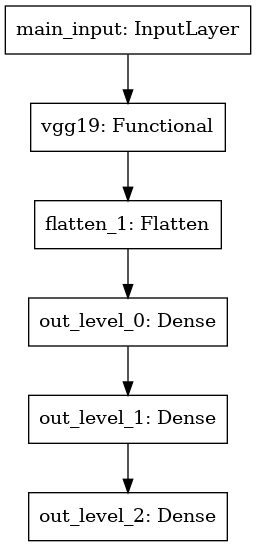

In [10]:
# Create the model
model = models.get_BCNN1(num_classes, dataset.image_size)
model.summary()
plot_model(model)


Model: "Model_BCNN1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
out_level_2 (Dense)          (None, 100)               51300     
_________________________________________________________________
out_level_1 (Dense)          (None, 20)                2020      
_________________________________________________________________
out_level_0 (Dense)          (None, 2)                 42        
Total params: 20,077,746
Trainable params: 20,077,746
Non-trainable params: 0
___________________________________________

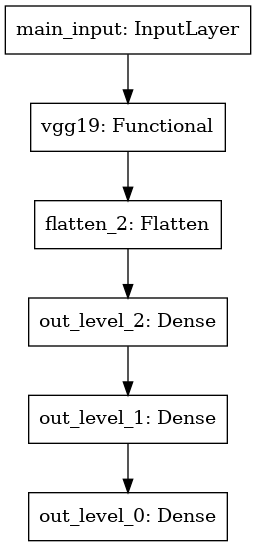

In [11]:
# Create the model
model = models.get_BCNN1(num_classes, dataset.image_size, reverse=True)
model.summary()
plot_model(model)


Model: "BCNN2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 512)          0           vgg19[3][0]                      
__________________________________________________________________________________________________
logits_level_0 (Dense)          (None, 2)            1026        flatten_10[0][0]                 
______________________________________________________________________________________________

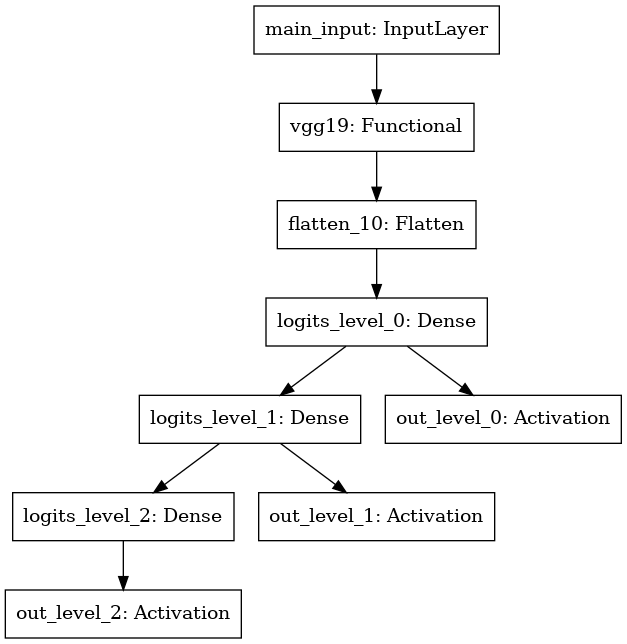

In [19]:
# Create the model
model = models.get_BCNN2(num_classes, dataset.image_size)
model.summary()
plot_model(model)


Model: "BCNN2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_16 (Flatten)            (None, 512)          0           vgg19[1][0]                      
__________________________________________________________________________________________________
logits_level_2 (Dense)          (None, 100)          51300       flatten_16[0][0]                 
______________________________________________________________________________________________

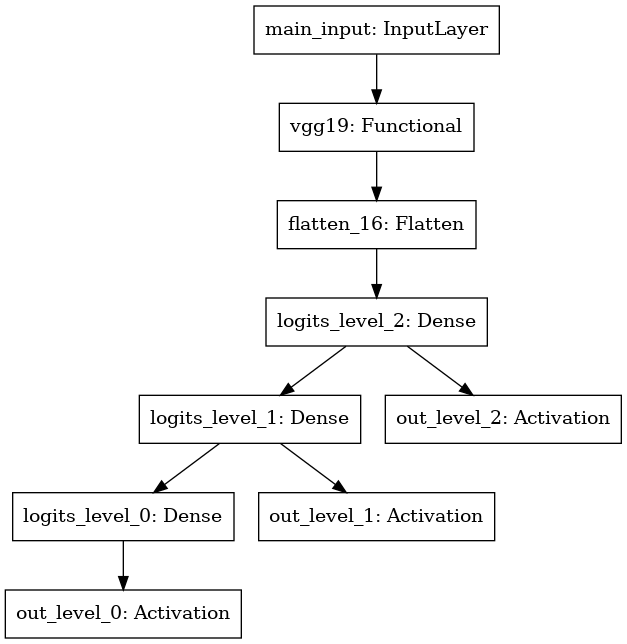

In [10]:
# Create the model
model = models.get_BCNN2(num_classes, dataset.image_size, reverse=True)
model.summary()
plot_model(model)


Model: "mnets"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv_base0 (Functional)         (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
conv_base1 (Functional)         (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
conv_base2 (Functional)         (None, None, None, 5 20024384    main_input[0][0]                 
______________________________________________________________________________________________

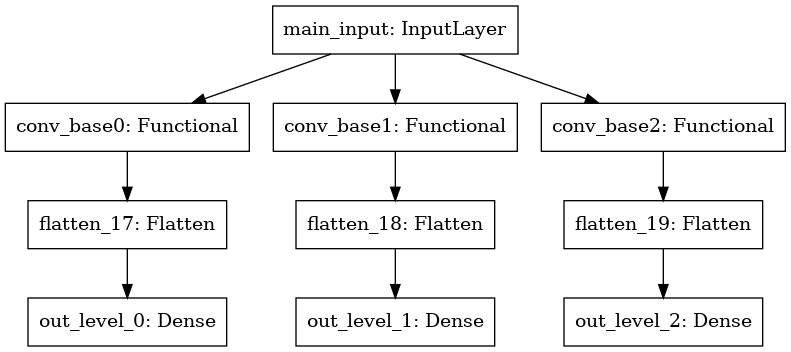

In [11]:
# Create the model
model = models.get_mnets(num_classes, dataset.image_size, reverse=True)
model.summary()
plot_model(model)


In [ ]:
class global_accuracy(keras.callbacks.Callback):
    """
    Each `SquadExample` object contains the character level offsets for each token
    in its input paragraph. We use them to get back the span of text corresponding
    to the tokens between our predicted start and end tokens.
    All the ground-truth answers are also present in each `SquadExample` object.
    We calculate the percentage of data points where the span of text obtained
    from model predictions matches one of the ground-truth answers.
    """

    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def on_epoch_end(self, epoch, logs=None):
      accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(self.model, self.x_eval, self.y_eval)

      accuracy_ci = 1.96 * np.std(accuracy) / np.sqrt(len(accuracy))
      accuracy = np.mean(accuracy)
      
      accuracy_c_ci = 1.96 * np.std(accuracy_c) / np.sqrt(len(accuracy_c))
      accuracy_c = np.mean(accuracy_c)
      
      accuracy_f_ci = 1.96 * np.std(accuracy_f) / np.sqrt(len(accuracy_f))
      accuracy_f = np.mean(accuracy_f)

      accuracy_c_no_f = np.mean(accuracy_c_no_f)

      accuracy_f_no_c = np.mean(accuracy_f_no_c)

      accuracy_no_f_no_c = np.mean(accuracy_no_f_no_c)

      accuracy_consistency = np.mean(accuracy_consistency)

      consistency = np.mean(consistency)


      print('-'*100)
      print(f"epoch={epoch+1}, global accuracy = {accuracy:.4f}±{accuracy_ci:.4f}, accuracy_c = {accuracy_c:.4f}±{accuracy_c_ci:.4f}, accuracy_f = {accuracy_f:.4f}±{accuracy_f_ci:.4f}, accuracy_c_no_f = {accuracy_c_no_f:.4f}, accuracy_f_no_c = {accuracy_f_no_c:.4f}, accuracy_no_f_no_c = {accuracy_no_f_no_c:.4f}, accuracy_consistency = {accuracy_consistency:.4f}, consistency = {consistency:.4f}")
      print('-'*100)
      print('')

def get_metrics(model, X, y):
  pred_c, pred_f = model.predict(X)
  accuracy = []
  accuracy_c = []
  accuracy_c_no_f = []
  accuracy_f = []
  accuracy_f_no_c = []
  accuracy_no_f_no_c = []
  accuracy_consistency = []
  consistency = []
  for idx, (c, f) in enumerate(zip(pred_c, pred_f)):
    c = np.argmax(c)
    f = np.argmax(f)
    if M[c][f] == 1:
      consistency.append(1)
    else:
      consistency.append(0)

    if y[0][idx][0] == c and y[1][idx][0] == f:
      accuracy.append(1)
      accuracy_c.append(1)
      accuracy_f.append(1)
      accuracy_c_no_f.append(0)
      accuracy_f_no_c.append(0)
      accuracy_no_f_no_c.append(0)
      accuracy_consistency.append(1)
    elif y[0][idx][0] == c and y[1][idx][0] != f:
      accuracy.append(0)
      accuracy_c.append(1)
      accuracy_f.append(0)
      accuracy_c_no_f.append(1)
      accuracy_f_no_c.append(0)
      accuracy_no_f_no_c.append(0)
      if M[c][f] == 1:
        accuracy_consistency.append(1)
      else:
        accuracy_consistency.append(0)

    elif y[0][idx][0] != c and y[1][idx][0] == f:
      accuracy.append(0)
      accuracy_c.append(0)
      accuracy_f.append(1)
      accuracy_c_no_f.append(0)
      accuracy_f_no_c.append(1)
      accuracy_no_f_no_c.append(0)
      accuracy_consistency.append(0)
    else:
      accuracy.append(0)
      accuracy_c.append(0)
      accuracy_f.append(0)    
      accuracy_c_no_f.append(0)
      accuracy_f_no_c.append(0)
      accuracy_no_f_no_c.append(1)
      accuracy_consistency.append(0)
    # break
  
  return accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency



In [ ]:
class Custom_Layer(keras.layers.Layer):
    def __init__(self, M, mode='both'):
        super(Custom_Layer, self).__init__()
        self.M = M
        if mode in ['both', 'c_to_f', 'f_to_c']:
          self.mode = mode

    def build(self, input_shape):
        """Creates scale variable if use_scale==True."""
        if isinstance(input_shape, list):
          input_dim1 = input_shape[0][1]
          input_dim2 = input_shape[0][1]
        else:
          input_dim1 = input_shape[1]
          input_dim2 = input_shape[1]
        
        units_c = len(self.M)
        units_f = len(self.M[0])
        self.M = tf.convert_to_tensor(self.M, dtype=tf.float32)

        self.W_c = self.add_weight(
            shape=(input_dim1, units_c), initializer="random_normal", trainable=True
        )
        self.b_c = self.add_weight(shape=(units_c,), initializer="zeros", trainable=True)
        self.W_f = self.add_weight(
            shape=(input_dim2, units_f), initializer="random_normal", trainable=True
        )
        self.b_f = self.add_weight(shape=(units_f,), initializer="zeros", trainable=True)

    def call(self, inputs):
      # Code the six equation
      if isinstance(inputs, list):
        inputs1 = inputs[0]
        inputs2 = inputs[1]
      else:
        inputs1 = inputs
        inputs2 = inputs
      
      z_c = tf.matmul(inputs1, self.W_c) + self.b_c # z^{(i)}_{c}= a^{[l]} \times W_{c} + b_{c}
      z_f = tf.matmul(inputs2, self.W_f) + self.b_f #  z^{(i)}_{f}= a^{[l]} \times  W_{f}+ b_{f}
      if self.mode == 'both' or self.mode == 'f_to_c':
        m_c = tf.matmul(tf.nn.softmax(z_f), tf.transpose(self.M)) # m^{(i)}_{c}= softmax(z^{(i)}_{f})\times M^{T}            
        y_c = tf.nn.softmax(z_c * m_c) # \hat{y}^{(i)}_{c}= softmax(z^{(i)}_{c}\circ m^{(i)}_{c})
      else:
        y_c = tf.nn.softmax(z_c)

      if self.mode == 'both' or self.mode == 'c_to_f':
        m_f = tf.matmul(tf.nn.softmax(z_c), self.M) #  m^{(i)}_{f}= softmax(z^{(i)}_{c})\times M
        y_f = tf.nn.softmax(z_f * m_f) # \hat{y}^{(i)}_{f}= softmax(z^{(i)}_{f}\circ m^{(i)}_{f})
      else:
        y_f = tf.nn.softmax(z_f)

      return y_c, y_f

    def get_config(self):
        config = {'M': self.M, 
                  'W_c': self.W_c,
                  'W_f': self.W_f,
                  'b_f': self.b_f,
                  'b_f': self.b_f}
        base_config = super(Custom_Layer, self).get_config()
        return base_config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
def get_model7(learning_rate=1e-5, pi=0.5, mode='both'):
    # Conv base
    in_layer = Input(shape=dataset.image_size, name='main_input')
    conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")(in_layer)
    conv_base = Flatten()(conv_base)
    # outputs 
    out_c, out_f = Custom_Layer(M, mode)(conv_base)
    # Build the model
    model = Model(name='Model_7',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

model = get_model7()
model.summary()
plot_model(model)


In [ ]:
def get_model8(learning_rate=1e-5, pi=0.5, mode='both'):
    # Conv base
    conv_base1 = keras.applications.VGG19(
    include_top=False,
    weights="imagenet")
    conv_base1._name = 'vgg19_1'
    conv_base2 = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")
    conv_base2._name = 'vgg19_2'
    in_layer = Input(shape=image_size, name='main_input')
    conv_base1 = conv_base1(in_layer)    
    conv_base1 = Flatten()(conv_base1)

    conv_base2 = conv_base2(in_layer)
    conv_base2 = Flatten()(conv_base2)

    out_c, out_f = Custom_Layer(M, mode)([conv_base1, conv_base2])
    # Build the model
    model = Model(name='Model_8',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

# model = get_model8()
# model.summary()
# plot_model(model)

In [ ]:
# Create the model
model1_pi1 = get_model1(pi=1)
model1_pi1.summary()
#train model
history_model1_pi1 = model1_pi1.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback]
                    )
plot_model(model1_pi1)



In [ ]:
# Create the model
model1_pi0 = get_model1(pi=0)
model1_pi0.summary()
#train model
history_model1_pi0 = model1_pi0.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model1_pi0)



In [ ]:
pred_c, _ = model1_pi0.predict(X_test)
_, pred_f = model1_pi1.predict(X_test)

accuracy_f = []
accuracy_c = []
consistency = []
consistency2 = []
consistency3 = []
for idx, (c, f) in enumerate(zip(pred_c, pred_f)):
  pred_c = np.argmax(c)
  pred_f = np.argmax(f)
  true_c = y_test[0][idx][0]
  true_f = y_test[1][idx][0]
  if true_c == pred_c:
    accuracy_c.append(100)
  else:
    accuracy_c.append(0)
  if true_f == pred_f:
    accuracy_f.append(100)
  else:
    accuracy_f.append(0)
    if mapping_fine_to_cluster[pred_f] != pred_c and true_c == pred_c:
      consistency2.append(100)
    else:
      consistency2.append(0)


    if mapping_fine_to_cluster[pred_f] != true_c:
      consistency3.append(100)
    else:
      consistency3.append(0)

  if M[pred_c][pred_f] == 0:
    consistency.append(100)
  else:
    consistency.append(0)


In [ ]:
data = pd.DataFrame(columns=['algo','accuracy'])
data_list = list(zip(['Coarse-grained\n classifier']*len(accuracy_c), accuracy_c))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy']),ignore_index=True)

data_list = list(zip(['Fine-grained\n classifier']*len(accuracy_f), accuracy_f))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy']),ignore_index=True)

plt.figure(figsize=(5.5, 3.8))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)

ax = sns.barplot(x="algo", y="accuracy", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("% correct predictions")
# plt.title("Box plot of #candidates per cycle and system")

plt.ylim(0, 100)
plt.xticks(rotation=0)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
data = pd.DataFrame(columns=['algo','consistency'])

data_list = list(zip(['XXX']*len(consistency), consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','consistency']),ignore_index=True)

plt.figure(figsize=(2, 3.8))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
ax = sns.barplot(x="algo", y="consistency", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("% inconsistent preds")
# plt.title("Box plot of #candidates per cycle and system")

plt.ylim(0, 100)
plt.xticks(rotation=0)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
data = pd.DataFrame(columns=['algo','consistency2'])

data_list = list(zip(['XXX']*len(consistency2), consistency2))
data = data.append(pd.DataFrame(data_list, columns=['algo','consistency2']),ignore_index=True)

plt.figure(figsize=(2, 3.8))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
ax = sns.barplot(x="algo", y="consistency2", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("% inconsistent preds")
# plt.title("Box plot of #candidates per cycle and system")
plt.ylim(0, 100)
plt.xticks(rotation=0)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
data = pd.DataFrame(columns=['algo','consistency3'])

data_list = list(zip(['XXX']*len(consistency3), consistency3))
data = data.append(pd.DataFrame(data_list, columns=['algo','consistency3']),ignore_index=True)

plt.figure(figsize=(2, 3.8))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
ax = sns.barplot(x="algo", y="consistency3", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("% inconsistent preds")
# plt.title("Box plot of #candidates per cycle and system")
plt.ylim(0, 100)
plt.xticks(rotation=0)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# Create the model
model1_pi0_5 = get_model1(pi=0.5)
model1_pi0_5.summary()
#train model
history_model11_pi0_5 = model1_pi0_5.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model1_pi0_5)


In [ ]:
# Create the model
model2 = get_model2(pi=0.5)
model2.summary()
#train model
history_model2 = model2.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model2)


In [ ]:
# Create the model
model3 = get_model3(pi=0.5)
model3.summary()
#train model
history_model3 = model3.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model3)


In [ ]:
# Create the model
model4 = get_model4(pi=0.5)
model4.summary()
#train model
history_model4 = model4.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model4)


In [ ]:
# Create the model
model5 = get_model5(pi=0.5)
model5.summary()
#train model
history_model5 = model5.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model5)


In [ ]:
# Create the model
model6 = get_model6(pi=0.5)
model6.summary()
#train model
history_model6 = model6.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model6)



In [ ]:
# Create the model
model7_pi_0_1 = get_model7(pi=0.1)
model7_pi_0_1.summary()
#train model
history_model7_pi_0_1 = model7_pi_0_1.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_pi_0_1)


In [ ]:
# Create the model
model7_pi_0_3 = get_model7(pi=0.3)
model7_pi_0_3.summary()
#train model
history_model7_pi_0_3 = model7_pi_0_3.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_pi_0_3)


In [ ]:
# Create the model
model7_pi_0_5 = get_model7(pi=0.5)
model7_pi_0_5.summary()
#train model
history_model7_pi_0_5 = model7_pi_0_5.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_pi_0_5)


In [ ]:
# Create the model
model7_pi_0_7 = get_model7(pi=0.7)
model7_pi_0_7.summary()
#train model
history_model7_pi_0_7 = model7_pi_0_7.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_pi_0_7)


In [ ]:
# Create the model
model7_pi_0_9 = get_model7(pi=0.9)
model7_pi_0_9.summary()
#train model
history_model7_pi_0_9 = model7_pi_0_9.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_pi_0_9)


In [ ]:
# Create the model
model7_c_to_f_pi_0_1 = get_model7(pi=0.1, mode='c_to_f')
model7_c_to_f_pi_0_1.summary()
#train model
history_model7_c_to_f_pi_0_1 = model7_c_to_f_pi_0_1.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_c_to_f_pi_0_1)


In [ ]:
# Create the model
model7_c_to_f_pi_0_3 = get_model7(pi=0.3, mode='c_to_f')
model7_c_to_f_pi_0_3.summary()
#train model
history_model7_c_to_f_pi_0_3 = model7_c_to_f_pi_0_3.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_c_to_f_pi_0_3)


In [ ]:
# Create the model
model7_c_to_f_pi_0_5 = get_model7(pi=0.5, mode='c_to_f')
model7_c_to_f_pi_0_5.summary()
#train model
history_model7_c_to_f_pi_0_5 = model7_c_to_f_pi_0_5.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_c_to_f_pi_0_5)


In [ ]:
# Create the model
model7_c_to_f_pi_0_7 = get_model7(pi=0.7, mode='c_to_f')
model7_c_to_f_pi_0_7.summary()
#train model
history_model7_c_to_f_pi_0_7 = model7_c_to_f_pi_0_7.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_c_to_f_pi_0_7)


In [ ]:
# Create the model
model7_c_to_f_pi_0_9 = get_model7(pi=0.9, mode='c_to_f')
model7_c_to_f_pi_0_9.summary()
#train model
history_model7_c_to_f_pi_0_9 = model7_c_to_f_pi_0_9.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_c_to_f_pi_0_9)


In [ ]:
# Create the model
model7_f_to_c_pi_0_1 = get_model7(pi=0.1, mode='f_to_c')
model7_f_to_c_pi_0_1.summary()
#train model
history_model7_f_to_c_pi_0_1 = model7_f_to_c_pi_0_1.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_f_to_c_pi_0_1)


In [ ]:
# Create the model
model7_f_to_c_pi_0_3 = get_model7(pi=0.3, mode='f_to_c')
model7_f_to_c_pi_0_3.summary()
#train model
history_model7_f_to_c_pi_0_3 = model7_f_to_c_pi_0_3.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_f_to_c_pi_0_3)


In [ ]:
# Create the model
model7_f_to_c_pi_0_5 = get_model7(pi=0.5, mode='f_to_c')
model7_f_to_c_pi_0_5.summary()
#train model
history_model7_f_to_c_pi_0_5 = model7_f_to_c_pi_0_5.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_f_to_c_pi_0_5)

In [ ]:
# Create the model
model7_f_to_c_pi_0_7 = get_model7(pi=0.7, mode='f_to_c')
model7_f_to_c_pi_0_7.summary()
#train model
history_model7_f_to_c_pi_0_7 = model7_f_to_c_pi_0_7.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_f_to_c_pi_0_7)


In [ ]:
# Create the model
model7_f_to_c_pi_0_9 = get_model7(pi=0.9, mode='f_to_c')
model7_f_to_c_pi_0_9.summary()
#train model
history_model7_f_to_c_pi_0_9 = model7_f_to_c_pi_0_9.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model7_f_to_c_pi_0_9)


In [ ]:
# # # Create the model
model8 = get_model8(pi=0.5)
model8.summary()
plot_model(model8)
#train model
history_model8 = model8.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model8)



In [ ]:
# # # Create the model
model8_c_to_f = get_model8(pi=0.5, mode='c_to_f')
model8_c_to_f.summary()
plot_model(model8_c_to_f)
#train model
history_model8_c_to_f = model8_c_to_f.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model8_c_to_f)



In [ ]:
# # # Create the model
model8_f_to_c = get_model8(pi=0.5, mode='f_to_c')
model8_f_to_c.summary()
plot_model(model8_f_to_c)
#train model
history_model8_f_to_c = model8_f_to_c.fit(X_train, 
                    y_train,
                    validation_data = (X_val, y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[global_accuracy_callback, early_stopping_callback])
plot_model(model8_f_to_c)



In [ ]:
data = pd.DataFrame(columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency'])

# accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model1_pi1, X_test, y_test)
# data_list = list(zip(['model1_pi1']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
# data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

# accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model1_pi0, X_test, y_test)
# data_list = list(zip(['model1_pi0']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
# data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model1_pi0_5, X_test, y_test)
data_list = list(zip(['model1_pi0.5']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

# accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model2, X_test, y_test)
# data_list = list(zip(['model2']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
# data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

# accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model3, X_test, y_test)
# data_list = list(zip(['model3']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
# data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

# accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model4, X_test, y_test)
# data_list = list(zip(['model4']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
# data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model5, X_test, y_test)
data_list = list(zip(['model5']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model6, X_test, y_test)
data_list = list(zip(['model6']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)


accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_pi_0_1, X_test, y_test)
data_list = list(zip(['model7_pi_0_1']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_pi_0_3, X_test, y_test)
data_list = list(zip(['model7_pi_0_3']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_pi_0_5, X_test, y_test)
data_list = list(zip(['model7_pi_0_5']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_pi_0_7, X_test, y_test)
data_list = list(zip(['model7_pi_0_7']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_pi_0_9, X_test, y_test)
data_list = list(zip(['model7_pi_0_9']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_c_to_f_pi_0_1, X_test, y_test)
data_list = list(zip(['model7_c_to_f_pi_0_1']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_c_to_f_pi_0_3, X_test, y_test)
data_list = list(zip(['model7_c_to_f_pi_0_3']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_c_to_f_pi_0_5, X_test, y_test)
data_list = list(zip(['model7_c_to_f_pi_0_5']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_c_to_f_pi_0_7, X_test, y_test)
data_list = list(zip(['model7_c_to_f_pi_0_7']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_c_to_f_pi_0_9, X_test, y_test)
data_list = list(zip(['model7_c_to_f_pi_0_9']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_f_to_c_pi_0_1, X_test, y_test)
data_list = list(zip(['model7_f_to_c_pi_0_1']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_f_to_c_pi_0_3, X_test, y_test)
data_list = list(zip(['model7_f_to_c_pi_0_3']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_f_to_c_pi_0_5, X_test, y_test)
data_list = list(zip(['model7_f_to_c_pi_0_5']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_f_to_c_pi_0_7, X_test, y_test)
data_list = list(zip(['model7_f_to_c_pi_0_7']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_f_to_c_pi_0_9, X_test, y_test)
data_list = list(zip(['model7_f_to_c_pi_0_9']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)





accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model8, X_test, y_test)
data_list = list(zip(['model8']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model8_c_to_f, X_test, y_test)
data_list = list(zip(['model8_c_to_f']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model8_f_to_c, X_test, y_test)
data_list = list(zip(['model8_f_to_c']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)


In [ ]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(20, 3.8))

ax = sns.barplot(x="algo", y="accuracy", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Accuracy")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.3, 0.52)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(20, 3.8))

ax = sns.barplot(x="algo", y="accuracy_c", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Accuracy_c")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.7, 0.85)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(20, 3.8))

ax = sns.barplot(x="algo", y="accuracy_f", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Accuracy_f")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.4, 0.55)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(20, 3.8))

ax = sns.barplot(x="algo", y="accuracy_consistency", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("accuracy_consistency")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.65, 0.85)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(20, 3.8))

ax = sns.barplot(x="algo", y="consistency", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.7, 1.)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()


In [ ]:
out_f_accuracy = history.history['out_f_accuracy']
out_c_accuracy = history.history['out_c_accuracy']
val_out_f_accuracy = history.history['val_out_f_accuracy']
val_out_c_accuracy = history.history['val_out_c_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(15,4))

ax1 = plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.fill_between(epochs, loss,val_loss,color='g',alpha=.1)

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ax2 = plt.subplot(1, 2, 2)
plt.plot(epochs, out_f_accuracy, label='Training f accuracy')
plt.plot(epochs, out_c_accuracy, label='Training c accuracy')
plt.plot(epochs, val_out_f_accuracy, label='Validation f accuracy')
plt.plot(epochs, val_out_c_accuracy, label='Validation c accuracy')
# plt.fill_between(epochs, acc,val_acc,color='g',alpha=.1)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
def nin(input_shape):
    # Define Network in Network model
    input = Input(shape=input_shape)
    x = Conv2D(filters=192, kernel_size=(5,5), activation='relu')(input)
    x = Conv2D(filters=160, kernel_size=(1,1), activation='relu')(x)
    x = Conv2D(filters=96, kernel_size=(1,1), activation='relu')(x)
    x = MaxPool2D(2, strides=2, padding='same')(x)
    x = Dropout(0.5)(x)

    x = Conv2D(filters=192, kernel_size=(5,5), activation='relu')(x)
    x = Conv2D(filters=192, kernel_size=(1,1), activation='relu')(x)
    x = Conv2D(filters=192, kernel_size=(1,1), activation='relu')(x)
    x = MaxPool2D(2, strides=2, padding='same')(x)
    x = Dropout(0.5)(x)

    x = Conv2D(filters=192, kernel_size=(3,3), activation='relu')(x)
    x = Conv2D(filters=192, kernel_size=(1,1), activation='relu')(x)
    x = Conv2D(filters=10, kernel_size=(1,1), activation='relu')(x)

    output = GlobalAveragePooling2D()(x)

    model = Model(input, output)

    return model 


    
model = nin(input_shape=(28,28,1))

model.summary()


In [ ]:
conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")
type(model)